In [1]:
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [225]:
def filter_df(df, num_sources=None, num_targets=None):
    """
    A function to filter the data frame by top n sources and targets
    If num_sources or num_targets args are not supplied, they will not be filtered
    """
    if num_targets:
        top_targets = df.sum().sort_values(ascending=False)
        df = df[top_targets[:num_targets].index]
    
    if num_sources:
        top_sources = df.sum(axis=1).sort_values(ascending=False)[:num_sources]
        df = df.loc[top_sources.index]
    
    return df


def create_sankey_df(df, min_val=0):
    """
    Create the human-readable form of the Sankey chart data from an input data frame
    Data can be filtered by a threshold minimum value
    | Source | Source Value | Target | Target Value |
    |    A   |      5       |   i    |      3       |
    |    A   |      5       |   j    |      2       |
    |    B   |      7       |   i    |      1       |
    |    B   |      7       |   k    |      4       |
    """
    
    sources = []
    source_vals = []
    targets = []
    target_vals = []
    for source_name in df.index:
        row = df.loc[source_name]
        sources += [source_name] * sum(row.values > min_val)
        source_vals += [row[row.values > min_val].sum()] * sum(row.values > min_val)
        targets += list(row[row > min_val].index)
        target_vals += list(row[row > min_val].values)
    
    sankey_df = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': target_vals
    })
    
    return sankey_df


def create_label_dict(node_df, start_idx=0):
    """
    Return a dictionary with labels as keys and indices as values.  Applied 
    to each section of the flow visualization (two nodes and an edge). The
    `node_df` represents each section.
    """
    labels = set(node_df.source).union(node_df.target)
    sorted_labels = sorted(list(labels))
    return {sorted_labels[i]: i + start_idx for i in range(len(sorted_labels))}


def create_final_list(node_df, node_label_dict):
    """
    Return a list of dictionaries and the labels for each section of the flow 
    diagram.
    """
    df = pd.DataFrame({
        "source": node_df.source.map(node_label_dict),
        "target": node_df.target.map(node_label_dict),
        "value" : node_df.value
    })
    
    labels = list(node_label_dict.keys())
    return df.to_dict("records"), labels

In [226]:
investor = pd.read_excel(
    "../data/Equity investor SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=3,
    usecols="B, E:GG",
)

investor = investor.rename(columns={investor.columns[0]: "Ultimate Investor"})

# drop last row because it is a table summary
investor = investor[:-1]
investor = investor.set_index('Ultimate Investor')

# Set the value of Kingdom of Saudi Arabia investment in Saudi Arabian Oil company to equal
# the second largest investment
investor.loc['KINGDOM OF SAUDI ARABIA', ('Saudi Arabian Oil Co')] = investor.max(axis=0).sort_values(ascending=False)[1]

In [4]:
financer = pd.read_excel(
    "../data/Financing SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=4,
    usecols="A:AV",
)

# drop last row because it is null
financer = financer[:-1]
financer = financer.set_index('Bank')

In [5]:
producer = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Conversion",
    engine="openpyxl",
    skiprows=1,
    usecols="C:FY",
).dropna()

producer = producer.groupby('Producer').sum()

In [6]:
waste = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Waste",
    engine="openpyxl",
    skiprows=1,
    usecols="B, D:FY",
).dropna()

waste = waste.groupby('Country').sum()

In [7]:
destination = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Waste",
    engine="openpyxl",
    skiprows=1,
    usecols="C:FY",
).dropna()

destination = destination.groupby('Producer').sum()

In [227]:
investor_df = create_sankey_df(investor)
financer_df = create_sankey_df(financer)
producer_df = create_sankey_df(producer)
waste_df = create_sankey_df(waste)
destination_df = create_sankey_df(destination)

## Circle Packing Diagram - Investor

In [293]:
import circlify as circ
num_circles = len(investor_df.groupby('source').sum())
circles = circ.circlify(list(investor_df.groupby('source').sum().sort_values(by='value', ascending=True)['value'])[:num_circles], show_enclosure=False)

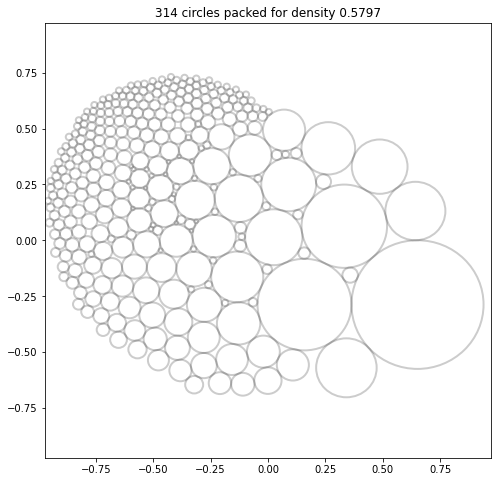

In [294]:
num_labels = 0
labels = [''] * (num_circles - num_labels)
top_labels = list(investor_df.groupby('source').sum().sort_values(by='value', ascending=True).index[:num_labels])
labels += top_labels[::-1]
circ.bubbles(circles, labels)

## Treemap Viz

In [281]:
investor_df_mod = destination_df.copy()
for index in range(len(investor_df_mod)):
    investor_df_mod.loc[index, 'target'] += '_' + str(index)
investor_df_mod

source           target      value
0      ABU DHABI NATIONAL OIL COMPANY (ADNOC)        Algeria_0   1.206092
1      ABU DHABI NATIONAL OIL COMPANY (ADNOC)      Argentina_1   0.001858
2      ABU DHABI NATIONAL OIL COMPANY (ADNOC)      Australia_2  14.574030
3      ABU DHABI NATIONAL OIL COMPANY (ADNOC)        Austria_3   1.739902
4      ABU DHABI NATIONAL OIL COMPANY (ADNOC)        Bahrain_4   1.245451
...                                       ...              ...        ...
28823                  Zibo Yuanshun Chemical  Venezuela_28823   0.007809
28824                  Zibo Yuanshun Chemical    Vietnam_28824   0.290263
28825                  Zibo Yuanshun Chemical      Yemen_28825   0.009515
28826                  Zibo Yuanshun Chemical     Zambia_28826   0.000025
28827                  Zibo Yuanshun Chemical   Zimbabwe_28827   0.000073

[28828 rows x 3 columns]

In [282]:
unique_investors = list(investor_df_mod['source'].unique())
labels = [''] + unique_investors + list(investor_df_mod['target'])

investor_parents = [''] * len(unique_investors)
parents = [''] + investor_parents + list(investor_df_mod['source'])

total = [investor_df_mod[investor_df_mod['source'] == investor].sum()['value'] for investor in unique_investors]
values = [investor_df_mod['value'].sum()] + total + list(investor_df_mod['value'])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Treemap(
    branchvalues = "total",
    labels = labels,
    values = values,
    parents = parents,
    #marker_colorscale = 'Blues'
    #marker_colors = ['white'] * len(list(investor_df['source'][:num_investors])) + ['lightgray'] * len(list(investor_df['source'][:num_investors].unique()))
))

fig.update_layout(
    title_text="Financers of Plastics Producers", 
    font_size=12,
    autosize=False,
    width=1500,
    height=1500,
    #uniformtext=dict(minsize=8, mode='hide'),
    treemapcolorway = ['#c9c3bc'] * len(values)
    #treemapcolorway = ['#F1D26D'] * len(values)
)
fig.write_html('../figures/destination_treemap.html', include_plotlyjs='cdn')
fig.show()

## Make a regional treemap

In [302]:
with open('../data/region_map.json', 'r') as f:
    region_dict = json.load(f)
country_to_region = { country['name']: country['region'] for country in region_dict }

In [327]:
# Assign regions to countries
df = destination_df.copy()
region = [country_to_region[country] for country in df['target']]
df['region'] = region
df.head()

source     target      value    region
0  ABU DHABI NATIONAL OIL COMPANY (ADNOC)    Algeria   1.206092    Africa
1  ABU DHABI NATIONAL OIL COMPANY (ADNOC)  Argentina   0.001858  Americas
2  ABU DHABI NATIONAL OIL COMPANY (ADNOC)  Australia  14.574030   Oceania
3  ABU DHABI NATIONAL OIL COMPANY (ADNOC)    Austria   1.739902    Europe
4  ABU DHABI NATIONAL OIL COMPANY (ADNOC)    Bahrain   1.245451      Asia

### Producers as regional subset

In [399]:
regional_df = df.groupby(['region', 'source']).sum()
unique_regions = list(regional_df.index.get_level_values('region').unique())
region_list = []
producer_list = []
values_list = list(regional_df['value'])
for region in unique_regions: 
    regional_producers = regional_df.loc[region].index
    for producer in regional_producers:
        region_list.append(region)
        producer_list.append(producer + ' - ' + region)

In [401]:
labels = [''] + unique_regions + producer_list

parent_group = [''] * len(unique_regions)
parents = [''] + parent_group + region_list

parent_total = list(df.groupby('region').sum()['value'])
values = [sum(parent_total)] + parent_total + values_list

In [442]:
import plotly.graph_objects as go

# Colors from https://coolors.co/3c905f-f4b393-fc60a8-8acdea-2d728f
color_array = ["#3c905f","#f4b393","#fc60a8","#8acdea","#2d728f"]

fig = go.Figure(go.Treemap(
    branchvalues = "total",
    labels = labels,
    values = values,
    parents = parents,
    #marker_colorscale = 'Blues'
    #marker_colors = ['white'] * len(list(investor_df['source'][:num_investors])) + ['lightgray'] * len(list(investor_df['source'][:num_investors].unique()))
))

fig.update_layout(
    title_text="Volume of Plastics by Region and Producer", 
    font_size=12,
    autosize=False,
    width=750,
    height=750,
    uniformtext=dict(minsize=8, mode='hide'),
    #treemapcolorway = ['#c9c3bc'] * len(values)
    treemapcolorway = color_array
    #treemapcolorway = ['#F1D26D'] * len(values)
)
fig.write_html('../figures/region_treemap.html', include_plotlyjs='cdn')
fig.show()

### Countries as regional subset

In [495]:
regional_df = df.groupby(['region', 'target']).sum()
unique_regions = list(regional_df.index.get_level_values('region').unique())
region_list = []
country_list = list(regional_df.index.get_level_values(1))
values_list = list(regional_df['value'])
for region in unique_regions: 
    country = regional_df.loc[region].index
    for value in country:
        region_list.append(region)

In [496]:
labels = [''] + unique_regions + country_list

parent_group = [''] * len(unique_regions)
parents = [''] + parent_group + region_list

parent_total = list(df.groupby('region').sum()['value'])
values = [sum(parent_total)] + parent_total + values_list

In [469]:
import plotly.graph_objects as go

# Colors from https://coolors.co/3c905f-f4b393-fc60a8-8acdea-2d728f
color_array = ["#3c905f","#f4b393","#fc60a8","#8acdea","#2d728f"]

fig = go.Figure(go.Treemap(
    branchvalues = "total",
    labels = labels,
    values = values,
    parents = parents,
    #marker_colorscale = 'Blues'
    #marker_colors = ['white'] * len(list(investor_df['source'][:num_investors])) + ['lightgray'] * len(list(investor_df['source'][:num_investors].unique()))
))

fig.update_layout(
    title_text="Volume of Plastics by Region and Country", 
    font_size=12,
    autosize=False,
    width=750,
    height=750,
    uniformtext=dict(minsize=8, mode='hide'),
    #treemapcolorway = ['#c9c3bc'] * len(values)
    treemapcolorway = color_array
    #treemapcolorway = ['#F1D26D'] * len(values)
)
fig.write_html('../figures/region_country_treemap.html', include_plotlyjs='cdn')
fig.show()

### Region, Country, Producer Treemap

In [498]:
regional_df = df.groupby(['region', 'target']).sum()
unique_regions = list(regional_df.index.get_level_values('region').unique())
region_list = []
country_list = list(regional_df.index.get_level_values(1))
values_list = list(regional_df['value'])
for region in unique_regions: 
    country = regional_df.loc[region].index
    for value in country:
        region_list.append(region)

In [499]:
producer_list = [f"{source}_{index}" for index, source in enumerate(df['source'])]
producer_country_list = list(df['target'])
producer_values = list(df['value'])

In [500]:
labels = [''] + unique_regions + country_list + producer_list

parent_group = [''] * len(unique_regions)
parents = [''] + parent_group + region_list + producer_country_list

parent_total = list(df.groupby('region').sum()['value'])
values = [sum(parent_total)] + parent_total + values_list + producer_values

In [501]:
print(len([''] + unique_regions + country_list))

157


In [502]:
for i in range(10):
    print(labels[-i], '|', parents[-i], '|', values[-i])

 |  | 140466.13807041297
Zibo Yuanshun Chemical_28827 | Zimbabwe | 7.26988837720347e-05
Zibo Yuanshun Chemical_28826 | Zambia | 2.4549668873484213e-05
Zibo Yuanshun Chemical_28825 | Yemen | 0.009515315137063635
Zibo Yuanshun Chemical_28824 | Vietnam | 0.29026312952294975
Zibo Yuanshun Chemical_28823 | Venezuela | 0.007808582807137671
Zibo Yuanshun Chemical_28822 | Uzbekistan | 0.0012284720168704098
Zibo Yuanshun Chemical_28821 | United States | 2.9405182325701693
Zibo Yuanshun Chemical_28820 | United Kingdom | 0.45545827300145925
Zibo Yuanshun Chemical_28819 | Ukraine | 0.038912769014402965


In [503]:
import plotly.graph_objects as go

# Colors from https://coolors.co/3c905f-f4b393-fc60a8-8acdea-2d728f
color_array = ["#3c905f","#f4b393","#fc60a8","#8acdea","#2d728f"]

fig = go.Figure(go.Treemap(
    branchvalues = "total",
    labels = labels,
    values = values,
    parents = parents,
    #marker_colorscale = 'Blues'
    #marker_colors = ['white'] * len(list(investor_df['source'][:num_investors])) + ['lightgray'] * len(list(investor_df['source'][:num_investors].unique()))
))

fig.update_layout(
    title_text="Volume of Plastics by Region and Country", 
    font_size=12,
    autosize=False,
    width=750,
    height=750,
    uniformtext=dict(minsize=8, mode='hide'),
    #treemapcolorway = ['#c9c3bc'] * len(values)
    treemapcolorway = color_array
    #treemapcolorway = ['#F1D26D'] * len(values)
)
#fig.write_html('../figures/region_country_treemap.html', include_plotlyjs='cdn')
fig.show()

# Export JSON for D3

In [54]:
# Concatenate two (or more) dataframes together

df_1 = investor_df
df_2 = destination_df

full_df = pd.concat([df_1, df_2], ignore_index=True)

column_dict = {name: 1 for name in np.unique(df_1['source']) }
for name in np.unique(pd.concat([df_1['target'], df_2['source']])):
    column_dict[name] = 2
for name in np.unique(df_2['target']):
    column_dict[name] = 3
    
# For every unique name in dataframe, create a name to index dictionary
labels = np.unique([[full_df['source']] + [full_df['target']]])
total_idx_dict = { labels[i]: i for i in range(len(labels)) }

In [55]:
# Generate base structure for dataset and populate links
full_d3_dataset = {
    'links': [],
    'nodes': []
}

for src, tar, val in zip(list(full_df.source.map(total_idx_dict)), 
                         list(full_df.target.map(total_idx_dict)), 
                         list(full_df.value)):
    full_d3_dataset['links'].append({
        "source": src,
        "target": tar,
        "value": round(val, 3)
    })

for label in labels:
    full_d3_dataset['nodes'].append({
        "name": label,
        "column": column_dict[label],
        "hover": {},
        "locations": []
    })

## Add Hover Label Info

In [56]:
# Add investor value data
investor_value = pd.read_excel(
    "../data/Equity investor SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=3,
    usecols="B, GH",
)

investor_value = investor_value.rename(columns={investor_value.columns[0]: "Ultimate Investor"})
investor_value = investor_value[:-1]
investor_value = investor_value.set_index('Ultimate Investor')

for name in investor_value.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = investor_value.loc[name]['Holding - Single Use Plastic Adjusted (USD mn)']
        full_d3_dataset['nodes'][d3_node_index]['hover']['Total Value'] = round(value, 3)

        
# Add investor volume data
investor_volume = pd.read_excel(
    "../data/Equity investor SUP footprint matrix.xlsx",
    engine="openpyxl",
    skiprows=3,
    usecols="B, CV",
)

investor_volume = investor_volume.rename(columns={investor_volume.columns[0]: "Ultimate Investor"})
investor_volume = investor_volume[:-1]
investor_volume = investor_volume.set_index('Ultimate Investor')

for name in investor_volume.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = investor_volume.loc[name]['Footprint (kt)']
        full_d3_dataset['nodes'][d3_node_index]['hover']['Total Volume'] = round(value, 3)

        
# Add financer value data
financer_value = pd.read_excel(
    "../data/Financing SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=4,
    usecols="A:AV",
)

financer_value = financer[:-1]
financer_value = financer_value.sum(axis=1)
for name in financer_value.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = financer_value[name]
        full_d3_dataset['nodes'][d3_node_index]['hover']['Total Value'] = round(value, 3)        


# Add producer volume label
producer_total_volume = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Pivot - Waste",
    engine="openpyxl",
    skiprows=2,
    usecols="A:B",
).dropna().set_index('Row Labels')

for name in producer_total_volume.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = producer_total_volume.loc[name]['Sum of checksum']
        full_d3_dataset['nodes'][d3_node_index]['hover']['Total Volume'] = round(value, 3) 


# Add producer equity value label
equity_value = pd.read_excel(
    "../data/Equity investor SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=3,
    usecols="B, E:GG",
)

equity_value = equity_value.rename(columns={equity_value.columns[0]: "Ultimate Investor"})
equity_value = equity_value[:-1]
equity_value = equity_value.set_index('Ultimate Investor')
equity_value = equity_value.sum()
equity_value.head()

for name in equity_value.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = equity_value[name]
        full_d3_dataset['nodes'][d3_node_index]['hover']['Equity Value'] = round(value, 3)
        
        
# Add circularity score label
circularity = pd.read_excel(
    "../data/CA matrix.xlsx",
    sheet_name='Circularity Assessment',
    engine="openpyxl",
    skiprows=1,
    usecols="D, F",
).dropna().set_index('Polymer producers ranked by circularity score')

for name in circularity.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = circularity.loc[name]['Circularity\nscore']
        full_d3_dataset['nodes'][d3_node_index]['hover']['Circularity Score'] = value


# Add total financing value label
financer = pd.read_excel(
    "../data/Financing SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=4,
    usecols="A:AV",
)
financer = financer[:-1]
financer = financer.set_index('Bank')
financing_total = financer.sum()

for name in financing_total.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = financing_total[name]
        full_d3_dataset['nodes'][d3_node_index]['hover']['Total Financing'] = round(value, 3)
        
        
# Add total waste label
total_waste = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Waste",
    engine="openpyxl",
    skiprows=1,
    usecols="B:C, D:FY",
).dropna()
total_waste = total_waste.groupby('Producer').sum()
total_waste = total_waste.sum()

for name in total_waste.index:
    node_names = [node['name'] for node in full_d3_dataset['nodes']]
    if name in node_names:
        d3_node_index = node_names.index(name)
        value = total_waste[name]
        full_d3_dataset['nodes'][d3_node_index]['hover']['Total Waste'] = round(value, 3)

## Assign Regions to Countries

In [57]:
with open('../data/region_map.json', 'r') as f:
    region_dict = json.load(f)
country_to_region = { country['name']: country['region'] for country in region_dict }

for node in full_d3_dataset['nodes']:
    if node['name'] in country_to_region.keys():
        node['region'] = country_to_region[node['name']]

In [58]:
print("Nodes without a matched region:", [node['name'] for node in full_d3_dataset['nodes'] if 'region' not in list(node.keys()) and node['column'] == 3])

Nodes without a matched region: ['Kosovo']


## Add Producer Coordinates

In [59]:
locations = pd.read_csv('../data/producer_locations.csv')

node_names = [node['name'] for node in full_d3_dataset['nodes']]
for index in range(len(locations)):
    row = locations.loc[index]
    producer_name = row['Producer name']
    lon = row['city_lon']
    lat = row['city_lat']
    coords = []
    if producer_name in node_names:
        d3_node_index = node_names.index(producer_name)
        full_d3_dataset['nodes'][d3_node_index]['locations'].append([lat, lon])

## Inspect Node Data and Export

In [60]:
full_d3_dataset['nodes']

[{'name': 'ABERDEEN ASSET MANAGEMENT',
  'column': 1,
  'hover': {'Total Value': 43.783, 'Total Volume': 47.03},
  'locations': []},
 {'name': 'ABU DHABI NATIONAL OIL COMPANY (ADNOC)',
  'column': 2,
  'hover': {'Total Volume': 1054.974,
   'Equity Value': 1243.785,
   'Circularity Score': 'D-',
   'Total Financing': 1433.573},
  'locations': [[38.799561, 26.970740000000003],
   [30.447206800000004, 49.0716096],
   [10.393227699999999, -75.4832311],
   [36.93958129999999, 126.43432340000001],
   [-36.7866757, -73.1099531],
   [49.04142589999999, 24.3950384],
   [44.873999999999995, 20.647567300000002],
   [41.119997, 122.070714],
   [-22.740959399999998, -47.174281]]},
 {'name': 'ACCESS INDUSTRIES LLC',
  'column': 1,
  'hover': {'Total Value': 1501.365, 'Total Volume': 1344.696},
  'locations': []},
 {'name': 'AL ZAMIL HOLDING GROUP LTD',
  'column': 1,
  'hover': {'Total Value': 104.143},
  'locations': []},
 {'name': 'ALCO-NAPHTHA ZAO',
  'column': 2,
  'hover': {'Total Volume': 184

In [61]:
with open('../data/investor-producer-destination_labels_coords_regions.json', 'w') as f:
    json.dump(full_d3_dataset, f)

## Data Subset

In [ ]:
def create_top_producers(producer_dataframe, n=30):
    producer_total = producer_dataframe.groupby(by="source").sum().reset_index()
    producer_rank = producer_total.sort_values(by="value", ascending=False)
    return list(producer_rank.source[0:n])

top_producer_list = create_top_producers(producer_df, 10)
top_producer_index = [total_idx_dict[elem] for elem in top_producer_list]

In [ ]:
# Convert the dataframe into lists of source and target indices

source = []
target = []
value = []

for src, tar, val in zip(list(full_df.source.map(total_idx_dict)), list(full_df.target.map(total_idx_dict)), list(full_df.value)):
    if src in top_producer_index or tar in top_producer_index:
        if val > 0:
            source.append(src)
            target.append(tar)
            value.append(val)

In [ ]:
# Write full dataset for d3
filtered_d3_dataset = {
    'links': [],
    'nodes': []
}

for src, tar, val in zip(list(full_df.source.map(total_idx_dict)), 
                         list(full_df.target.map(total_idx_dict)), 
                         list(full_df.value)):
        if src in top_producer_index or tar in top_producer_index:
            filtered_d3_dataset['links'].append({
                "source": src,
                "target": tar,
                "value": val
            })

for label in labels:
    filtered_d3_dataset['nodes'].append({
        "name": label,
        "column": column_dict[label]
    })

In [ ]:
with open('../data/filtered_investor-producer-destintation.json', 'w') as f:
    json.dump(filtered_d3_dataset, f, indent = 4)

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "black"
    ),
    link = dict(
      source = [link['source'] for link in filtered_d3_dataset['links']],
      target = [link['target'] for link in filtered_d3_dataset['links']],
      value  = [link['value'] for link in filtered_d3_dataset['links']]
  ))])

#fig.update_layout(title_text=title, font_size=10)
fig.show()